### Causal relation detection

In this task, we will explore whether a causal relation can be detected by a NLP model given a sentence. We will use Large Pre-trained Language model as our encoder, then fine-tune it with our data. In addition, after getting the contextualised embedding of the input sentence, it will be pass to a shallow feed-forward neural network. Since huggingface provides a terrific module called BertForClassification, we will adopt it in the experiment.

### Dataset: Semeval-2010-Task 8

### An instance of our data:
#### with entity feature: Most of the <e1> taste <\e1> of strong onions comes from the <e2> smell <\e2>.
#### without entity feature: Most of the taste of strong onions comes from the smell.

[Relation Classification] SemEval-2010 Task 8: Multi-Way Classification of Semantic Relations Between Pairs of Nominals, see: https://arxiv.org/pdf/1911.10422.pdf (#dataset statistics: 10000 totally)

Cause-Effect (CE). An event or object yields an  effect. Example: those cancers were caused  by radiation exposures  (1134 totally)

Instrument-Agency (IA). An agent uses an instrument. Example: phone operator  

Product-Producer (PP). A producer causes a product to exist. Example: a factory manufactures suits  

Content-Container (CC). An object is physically stored in a delineated area of space. Example: a bottle full of honey was weighed 

 Entity-Origin (EO). An entity is coming or is derived from an origin (e.g., position or material). Example: letters from foreign countries  

Entity-Destination (ED). An entity is moving towards a destination. Eg. the boy went to bed 

 Component-Whole (CW). An object is a component of a larger whole. Example: my apartment has a large kitchen 

 Member-Collection (MC). A member forms a  nonfunctional part of a collection. Example:  there are many trees in the forest  

Communication-Topic (CT). An act of communication, written or spoken, is about a topic.  Example: the lecture was about semantics


### experiment planing
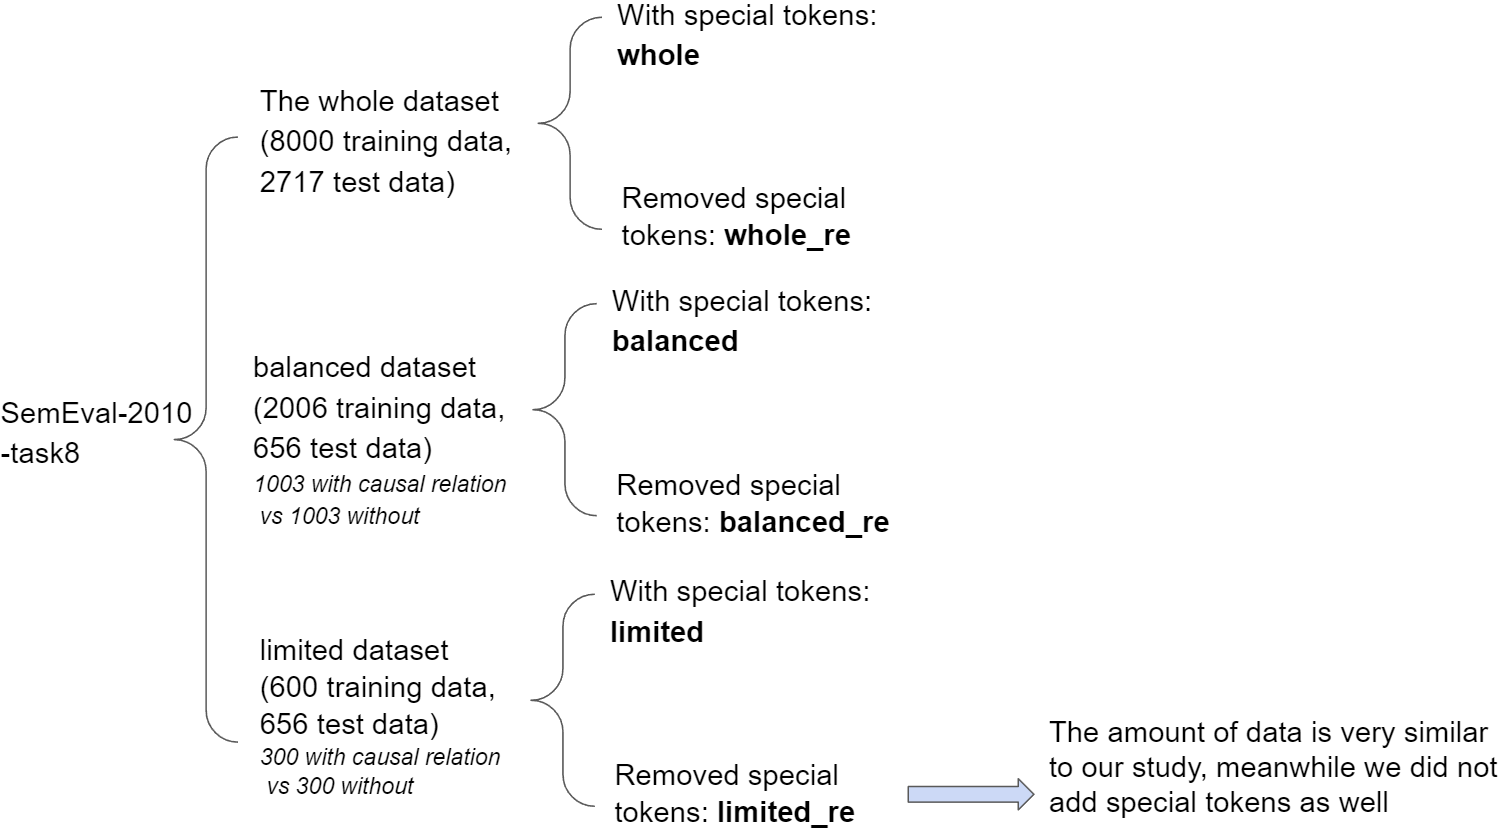

In [1]:
import pandas as pd
import random
import numpy as np
import warnings

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

from datasets import load_dataset

warnings.filterwarnings('ignore')

In [2]:
#set random seed to keep consistency between different experiments
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [3]:
def make_df(dataset_):
    index,sentence,relation = [],[],[]
    for ind,data in enumerate(dataset_):
        index.append(ind)
        sentence.append(data['sentence'])
        relation.append(data['relation'])
        
    df = pd.DataFrame({'index': index,
                       'sentence': sentence,
                       'relation': relation
                      })
    return df

def data_exploration(df_train,df_test):
    df_train['sentence_length'] = df_train['sentence'].str.split().str.len()
    df_test['sentence_length'] = df_test['sentence'].str.split().str.len()
    
    print('For training data(have not been splitted to validation set), the description of sentence length is:')
    print(df_train['sentence_length'].describe())
    
    print('\nFor test data, the description of sentence length is:')
    print(df_test['sentence_length'].describe())
    
    return

def split_dataset_by_causation(df_train,df_test,balance):
    df_causal_true = df_train[(df_train['relation'] == 0) | (df_train['relation'] == 1)]
    df_causal_true['relation'] = 1
    df_causal_false = df_train[(df_train['relation'] != 0) & (df_train['relation'] != 1)]
    df_causal_false['relation'] = 0
    
    # if you wanna re-sample, do it here
    if balance == True:
        df_causal_false = df_causal_false.sample(len(df_causal_true))
    
    frames = [df_causal_true,df_causal_false]
    df_train = pd.concat(frames)
    df_train = shuffle(df_train)
    
    
    df_causal_true = df_test[(df_test['relation'] == 0) | (df_test['relation'] == 1)]
    df_causal_true['relation'] = 1
    df_causal_false = df_test[(df_test['relation'] != 0) & (df_test['relation'] != 1)]
    df_causal_false['relation'] = 0
    
    # if you wanna re-sample, do it here
    if balance == True:
        df_causal_false = df_causal_false.sample(len(df_causal_true))
    
    frames = [df_causal_true,df_causal_false]
    df_test = pd.concat(frames)
    df_test = shuffle(df_test)
    return df_train,df_test
    

def dataset_loading(balance=False):
    dataset = load_dataset('sem_eval_2010_task_8')
    
    df_train = make_df(dataset['train'])
    df_test = make_df(dataset['test'])
    
    #demonstrate length of sentences
    data_exploration(df_train,df_test)
    
    # re-annotate data: if relation is not causal relation, then label it as 0, vice versa.
    df_train,df_test = split_dataset_by_causation(df_train,df_test,balance)
    
    #split to train, val, test dataset
    df_train,df_val = train_test_split(df_train,test_size=0.2, random_state = seed_val)
    
    train_ratio = len(df_train[df_train['relation']==1]) / len(df_train)
    print('\nOverall, we have {} vs {} of data that contains and not contains causal relation for training data.'.format(train_ratio, 1-train_ratio))
    
    val_ratio = len(df_val[df_val['relation']==1]) / len(df_val)
    print('\nOverall, we have {} vs {} of data that contains and not contains causal relation for validation data.'.format(val_ratio, 1-val_ratio))
    
    test_ratio = len(df_test[df_test['relation']==1]) / len(df_test)
    print('\nOverall, we have {} vs {} of data that contains and not contains causal relation for test data.'.format(test_ratio, 1-test_ratio))
    
    #remove special tokens indicating causal relation entities' positions.
    replace_values = {'<e1>': '', '</e1>': '', '<e2>': '', '</e2>': ''}
    df_train_re = df_train.replace(replace_values, regex=True)
    df_val_re = df_val.replace(replace_values, regex=True)
    df_test_re = df_test.replace(replace_values, regex=True)
    
    return df_train,df_val,df_test,df_train_re,df_val_re,df_test_re

In [4]:
df_train,df_val,df_test,df_train_re,df_val_re,df_test_re = dataset_loading()

Using custom data configuration default
Reusing dataset sem_eval2010_task8 (C:\Users\Tan\.cache\huggingface\datasets\sem_eval2010_task8\default\1.0.0\8545d1995bbbade386acf5c4e2bef5589d8387ae0a93356407dfb54cdb234416)


  0%|          | 0/2 [00:00<?, ?it/s]

For training data(have not been splitted to validation set), the description of sentence length is:
count    8000.000000
mean       17.199125
std         7.534907
min         3.000000
25%        12.000000
50%        16.000000
75%        21.000000
max        85.000000
Name: sentence_length, dtype: float64

For test data, the description of sentence length is:
count    2717.000000
mean       17.251748
std         7.498203
min         4.000000
25%        12.000000
50%        16.000000
75%        21.000000
max        60.000000
Name: sentence_length, dtype: float64

Overall, we have 0.125 vs 0.875 of data that contains and not contains causal relation for training data.

Overall, we have 0.126875 vs 0.873125 of data that contains and not contains causal relation for validation data.

Overall, we have 0.12072138387927861 vs 0.8792786161207213 of data that contains and not contains causal relation for test data.


In [5]:
df_train_balanced,df_val_balanced,df_test_balanced,df_train_re_balanced,df_val_re_balanced,df_test_re_balanced = dataset_loading(balance=True)

Using custom data configuration default
Reusing dataset sem_eval2010_task8 (C:\Users\Tan\.cache\huggingface\datasets\sem_eval2010_task8\default\1.0.0\8545d1995bbbade386acf5c4e2bef5589d8387ae0a93356407dfb54cdb234416)


  0%|          | 0/2 [00:00<?, ?it/s]

For training data(have not been splitted to validation set), the description of sentence length is:
count    8000.000000
mean       17.199125
std         7.534907
min         3.000000
25%        12.000000
50%        16.000000
75%        21.000000
max        85.000000
Name: sentence_length, dtype: float64

For test data, the description of sentence length is:
count    2717.000000
mean       17.251748
std         7.498203
min         4.000000
25%        12.000000
50%        16.000000
75%        21.000000
max        60.000000
Name: sentence_length, dtype: float64

Overall, we have 0.49625935162094764 vs 0.5037406483790523 of data that contains and not contains causal relation for training data.

Overall, we have 0.5149253731343284 vs 0.4850746268656716 of data that contains and not contains causal relation for validation data.

Overall, we have 0.5 vs 0.5 of data that contains and not contains causal relation for test data.


### Experiments

In [6]:
from collections import OrderedDict 
import itertools
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os
import pprint
from sklearn.utils import resample
from sklearn.metrics import classification_report,confusion_matrix,f1_score
import time
import datetime
import seaborn as sns
import torch
import tqdm
import warnings
from transformers import BertTokenizer,RobertaTokenizer,BertForSequenceClassification,get_linear_schedule_with_warmup,AdamW, BertConfig, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [7]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
if str(device) == 'cuda':
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
else:
    torch.manual_seed(seed_val)

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
def tokenize_process(df,tokenizer,max_length):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    
    sentences = df.X.values
    labels = df.y.values
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,   # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Print sentence 0, now as a list of IDs.
    #print('Check the original paragraph and converted paragrapg: ')
    #print('Original: ', sentences[1])
    #print('Token IDs:', input_ids[1])
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred

In [10]:
def Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps):
    print('\nTraining and evaluating the model.')
    
    #store a number of quantities such as training and validation loss,validation accuracy, and timings.
    training_stats = []
    total_t0 = time.time()
    
    #store prediction and true labels
    train_logits = []
    train_label = []
    best_loss = 1.0
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
    
            model.zero_grad()        
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            
            logits_ = logits.detach().cpu().numpy()
            label_ids_ = b_labels.to('cpu').numpy()
            
            #store prediction for the last epoch
            if epoch_i == epochs-1:
                train_logits.extend(logits_)
                train_label.extend(label_ids_)
            total_train_loss += loss.item()
    
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.Update the learning rate.
            optimizer.step()
        
        #Update scheduler(lr decay) every epoch
        lr_stat_opt = optimizer.param_groups[0]["lr"] #or lr_stat_scheduler = scheduler.get_last_lr()[0]
        print('current lr is:',lr_stat_opt)
        if scheduler:
            scheduler.step()
        
        #wandb.log({"lr": lr_stat_opt})
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
    
        print("")
        print("Running Validation...")
        eval_pred = []
        eval_label = []
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
            # `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            #total_eval_accuracy += flat_accuracy(logits, label_ids)
            eval_pred.extend(logits)
            eval_label.extend(label_ids)
        

        eval_pred = convert_logits_tolabel(eval_pred)
        f1_val = f1_score(eval_label,eval_pred,average='macro')
        
        
        # Report the final accuracy for this validation run.
        #avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Macro F1 score: {0:.2f}".format(f1_val))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
        
        
        #early-stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # At this point also save a snapshot of the current model
            torch.save(model, 'my_model_best_loss.pth')
            
        
        #wandb.log({"Training Loss": avg_train_loss, "Valid. Loss":avg_val_loss,"Valid. Macro F1":f1_val, "epoch": epoch_i + 1 })
        
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Macro F1.': f1_val,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print("")
    print("Training complete!")
    
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    pd.set_option('precision', 2)
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)
    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    
    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    
    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    epoch_list = [i+1 for i in range(epochs)]
    plt.xticks(epoch_list)
    
    plt.show()
    
    
    train_pred = convert_logits_tolabel(train_logits)
    
    return train_pred,eval_pred,train_label,eval_label

def get_prediction(df_test,model,batch_size,max_length,model_name):
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')

    test_dataset = tokenize_process(df_test,tokenizer,max_length)
    test_dataloader = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),batch_size = batch_size)
    
    test_logits = []
    test_label = []
    model.eval()
    
    for batch in test_dataloader:
        """
        Unpack this training batch from our dataloader.
        `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
        """
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            test_logits.extend(logits)
            test_label.extend(label_ids)
            
    def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred
    
    test_logits = convert_logits_tolabel(test_logits)
            
    return test_logits,test_label

In [11]:
def transformer_cls(df_train,df_val,
             epochs = 10,
             batch_size =16,
             max_length=128,
             model_name='roberta',
             lr = 5e-5,
             weight_decay = 1e-2,
             freeze_layer_count=1,
             scheduler_type='step',
             decayRate=0.75):
    
    
    #wandb update
    #wandb.config.max_length = max_length
    #wandb.config.model = model_name
    #wandb.config.weight_decay = weight_decay
    #wandb.config.freeze_layer_count = freeze_layer_count
    #wandb.config.optimizer = 'AdamW'
    #wandb.config.scheduler_type = scheduler_type
    #wandb.config.decayRate = decayRate
    
    
    print('\n======================Doing Bert classification task======================')
    
    """
    step1: Tokenization
    """
    #print('Do step1: Tokenization\n')
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
    
    train_dataset = tokenize_process(df_train,tokenizer,max_length)
    val_dataset = tokenize_process(df_val,tokenizer,max_length)
    
    """
    step2: create dataloader for both training and eval set
    """
    
    batch_size = batch_size
    
    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset), batch_size = batch_size)
    
    # For validation and test the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)
    
    """
    step3: load bert model
    """
    #print('Do step3: load bert model\n')
    model,optimizer,scheduler,total_steps = model_and_helper(epochs,train_dataloader,model_name,freeze_layer_count,lr,weight_decay,scheduler_type,decayRate)
    
    """
    step4: Training and evaluating
    """
    #print('Do step4: Training and evaluating\n')
    train_pred,eval_pred,train_label,eval_label = Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps)
    
    
    return train_pred,eval_pred,train_label,eval_label

In [12]:
def model_and_helper(epochs,train_dataloader,
                     model_name='roberta',
                     freeze_layer_count=1,
                     lr = 5e-5,
                     weight_decay = 1e-2,
                     scheduler_type='linear',
                     decayRate=0.75):
    
    if model_name == 'bert':
        print('\nLoading bert model.')
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",  num_labels = 2,  output_attentions = False, output_hidden_states = False,  return_dict = False)
        
        
    elif model_name == 'roberta':
        model = RobertaForSequenceClassification.from_pretrained(
            'roberta-base', num_labels = 2, output_attentions = False, output_hidden_states = False, return_dict = False)
        
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
        
    
    
    # Assign GPU if you have
    if str(device)=='cuda':
        model.cuda()
    else:
        pass
    
    # We freeze here the embeddings of the model
    if freeze_layer_count:
        if model_name == 'bert':
            for param in model.bert.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.bert.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
                        
        if model_name == 'roberta':
            for param in model.roberta.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.roberta.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
            
        
    
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch), the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = lr, 
                      eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                      weight_decay = weight_decay 
                    )
    
    epochs = epochs
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    
    # set learning rate decay
    if scheduler_type=='linear': 
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value
                                                num_training_steps = total_steps)
    elif scheduler_type=='step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decayRate)
        
    elif scheduler_type=='exponential':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
        
    elif scheduler_type=='none':
        scheduler = None
    
    else:
        raise SystemExit('Invalid scheduler_type, it could only be one of [linear, step, exponential,none] ')
    

    return model,optimizer,scheduler,total_steps

In [13]:
def evaluate_result(train_pred,train_label,eval_pred,eval_label,test_pred,test_true,args):
    
    training_pred,training_true,evaluation_pred,evaluation_true = [],[],[],[]
    
    training_pred.append(train_pred)
    training_true.append(train_label)
    evaluation_pred.append(eval_pred)
    evaluation_true.append(eval_label)
    
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    evaluation_true = flatten(evaluation_true)
    evaluation_pred = flatten(evaluation_pred)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    
    f1_train = f1_score(training_true, training_pred,average='macro')
    f1_val = f1_score(evaluation_true, evaluation_pred,average='macro')
    f1_test = f1_score(test_true,test_pred,average='macro')
    
    print({"f1_train": f1_train,"f1_val": f1_val, "f1_test": f1_test})
    #wandb.log({"f1_train": f1_train,"f1_val": f1_val, "f1_test": f1_test})

    print('\nargs:',args)
    target_names = ['class 0', 'class 1']
    #For evaluation data
    print('classification report on test set is:\n')
    clas_reprt_eval = classification_report(test_true, test_pred, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on test set is:\n')
    cm_eval = confusion_matrix(test_true, test_pred)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return 

In [14]:
def do_cls(df_train, df_val, df_test, args):
    
    df_train.rename(columns={"sentence": "X", "relation": "y"},inplace=True)
    df_val.rename(columns={"sentence": "X", "relation": "y"},inplace=True)
    df_test.rename(columns={"sentence": "X", "relation": "y"},inplace=True)
    
    train_pred,eval_pred,train_label,eval_label = transformer_cls(df_train,df_val,
                                                                          epochs = args['epochs'],
                                                                          batch_size =args['batch_size'],
                                                                          max_length=args['max_length'],
                                                                          model_name=args['model_name'],
                                                                          lr = args['lr'],
                                                                          weight_decay = args['weight_decay'],
                                                                          freeze_layer_count=args['freeze_layer_count'],
                                                                          scheduler_type=args['scheduler_type'],
                                                                          decayRate=args['decayRate'])
    
    #load best model
    model = torch.load('my_model_best_loss.pth')
    model.eval()
    
    test_pred,test_true = get_prediction(df_test,model,batch_size=args['batch_size'],max_length=args['max_length'],model_name=args['model_name'])
    
    # generate confusion matrix and classification report
    evaluate_result(train_pred,train_label,eval_pred,eval_label,test_pred,test_true,args)

    
    del model
    torch.cuda.empty_cache()
    
    #clear output if you want
    #clear_output(wait=True)
    return test_pred,test_true,df_test


In [15]:
best_args = {
    'epochs': 6,
    'batch_size': 20,
    'max_length': 60,
    'model_name': 'bert',
    'lr': 5e-05,
    'weight_decay': 0.05,
     'freeze_layer_count':0,
    'scheduler_type': 'none',
    'decayRate': 0.75
    }

### The whole dataset 
(8000 training data, 2717 test data)



======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:07.
  Batch    80  of    320.    Elapsed: 0:00:12.
  Batch   120  of    320.    Elapsed: 0:00:18.
  Batch   160  of    320.    Elapsed: 0:00:23.
  Batch   200  of    320.    Elapsed: 0:00:28.
  Batch   240  of    320.    Elapsed: 0:00:34.
  Batch   280  of    320.    Elapsed: 0:00:39.
current lr is: 5e-05

  Average training loss: 0.16
  Training epcoh took: 0:00:45

Running Validation...
  Macro F1 score: 0.91
  Validation Loss: 0.15
  Validation took: 0:00:03

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:05.
  Batch    80  of    320.    Elapsed: 0:00:11.
  Batch   120  of    320.    Elapsed: 0:00:16.
  Batch   160  of    320.    Elapsed: 0:00:22.
  Batch   200  of    320.    Elapsed: 0:00:28.
  Batch   240  of    320.    Elapsed: 0:00:33.
  Batch   280  of    320.    Elapsed: 0:00:39.
current lr is: 5e-05

  Average training

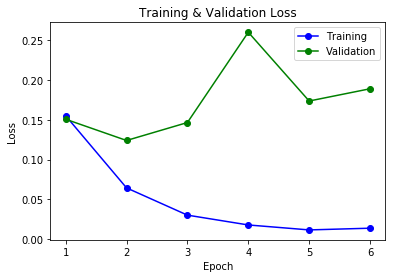

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.9925040152877931, 'f1_val': 0.9347324165050841, 'f1_test': 0.9400890835856879}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.99      0.98      0.98      2389
     class 1       0.86      0.94      0.90       328

    accuracy                           0.97      2717
   macro avg       0.92      0.96      0.94      2717
weighted avg       0.98      0.97      0.97      2717

confusion matrix on test set is:



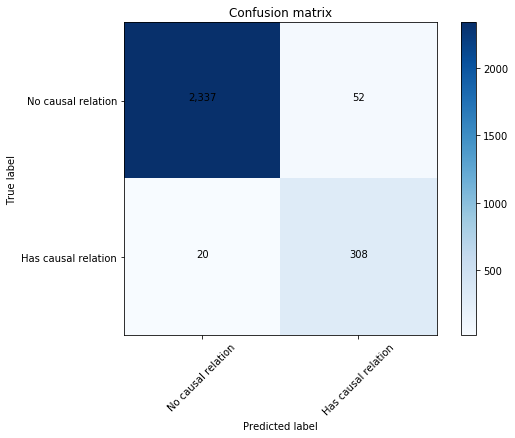

In [16]:
test_pred,test_true,df_test = do_cls(df_train, df_val, df_test,best_args)


======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:06.
  Batch    80  of    320.    Elapsed: 0:00:11.
  Batch   120  of    320.    Elapsed: 0:00:17.
  Batch   160  of    320.    Elapsed: 0:00:22.
  Batch   200  of    320.    Elapsed: 0:00:27.
  Batch   240  of    320.    Elapsed: 0:00:33.
  Batch   280  of    320.    Elapsed: 0:00:38.
current lr is: 5e-05

  Average training loss: 0.18
  Training epcoh took: 0:00:44

Running Validation...
  Macro F1 score: 0.91
  Validation Loss: 0.16
  Validation took: 0:00:03

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:05.
  Batch    80  of    320.    Elapsed: 0:00:11.
  Batch   120  of    320.    Elapsed: 0:00:16.
  Batch   160  of    320.    Elapsed: 0:00:22.
  Batch   200  of    320.    Elapsed: 0:00:27.
  Batch   240  of    320.    Elapsed: 0:00:33.
  Batch   280  of    320.    Elapsed: 0:00:38.
current lr is: 5e-05

  Average training

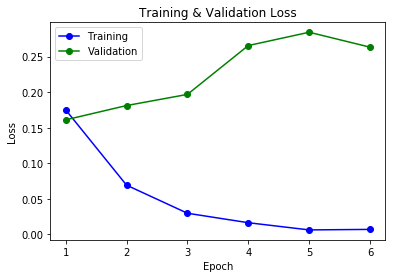

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.9975013384292644, 'f1_val': 0.9139164774622578, 'f1_test': 0.9353070917453037}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.99      0.98      0.98      2389
     class 1       0.87      0.91      0.89       328

    accuracy                           0.97      2717
   macro avg       0.93      0.94      0.94      2717
weighted avg       0.97      0.97      0.97      2717

confusion matrix on test set is:



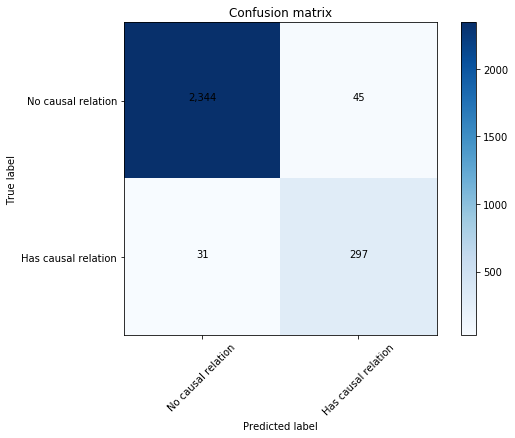

In [17]:
test_pred,test_true,df_test = do_cls(df_train_re,df_val_re,df_test_re,best_args)

### balanced dataset
(2006 training data, 656 test data)


======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:06.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.30
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.96
  Validation Loss: 0.16
  Validation took: 0:00:01

======== Epoch 2 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.10
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.96
  Validation Loss: 0.16
  Validation took: 0:00:01

======== Epoch 3 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:06.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.05
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.95
  Validation Loss: 0.18
  Validation took: 0:00:01

======== Epo

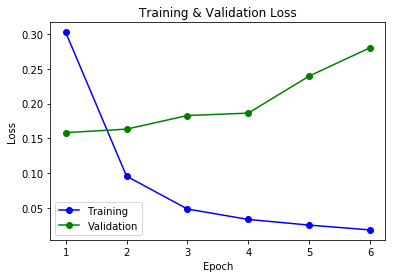

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.996259328358209, 'f1_val': 0.9576986165702084, 'f1_test': 0.9588367763841343}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96       328
     class 1       0.95      0.97      0.96       328

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656

confusion matrix on test set is:



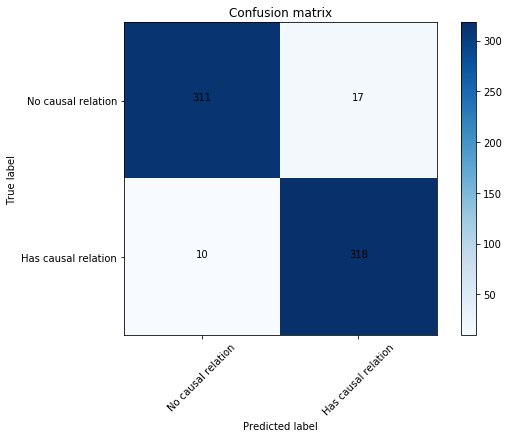

In [263]:
#kept the special token version
test_pred,test_true,df_test = do_cls(df_train_balanced,df_val_balanced,df_test_balanced,best_args)


======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:06.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.37
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.92
  Validation Loss: 0.22
  Validation took: 0:00:01

======== Epoch 2 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.13
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.94
  Validation Loss: 0.22
  Validation took: 0:00:01

======== Epoch 3 / 6 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.
current lr is: 5e-05

  Average training loss: 0.04
  Training epcoh took: 0:00:11

Running Validation...
  Macro F1 score: 0.94
  Validation Loss: 0.33
  Validation took: 0:00:01

======== Epo

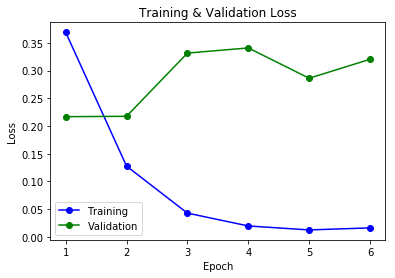

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.9968827918058625, 'f1_val': 0.9427573782061998, 'f1_test': 0.9328762918244142}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.96      0.91      0.93       328
     class 1       0.91      0.96      0.93       328

    accuracy                           0.93       656
   macro avg       0.93      0.93      0.93       656
weighted avg       0.93      0.93      0.93       656

confusion matrix on test set is:



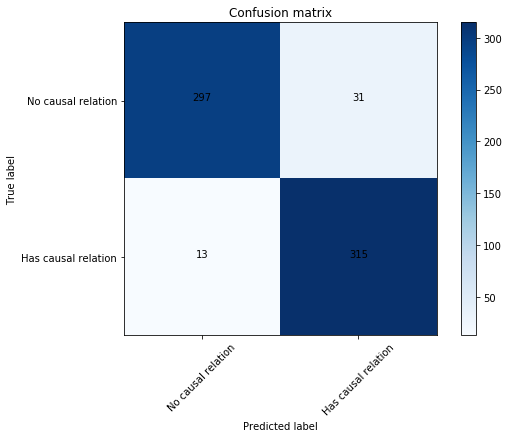

In [252]:
#removed the special token version
test_pred,test_true,df_test = do_cls(df_train_re_balanced,df_val_re_balanced,df_test_re_balanced,best_args)

### limited dataset 
(600 training data, 656 test data)



======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.54
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.90
  Validation Loss: 0.29
  Validation took: 0:00:01

======== Epoch 2 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.16
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.90
  Validation Loss: 0.46
  Validation took: 0:00:01

======== Epoch 3 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.08
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.94
  Validation Loss: 0.30
  Validation took: 0:00:01

======== Epoch 4 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.03
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.94
  Validation Loss: 0.30
  Validation took: 0:00:01

======== Epoch 5 / 6 ========
Training...
current lr is: 5e-05

  Avera

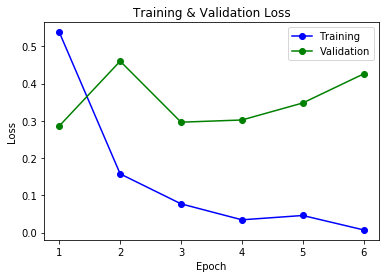

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.9966666296292181, 'f1_val': 0.9303206636127275, 'f1_test': 0.9192071293294759}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.92      0.92      0.92       328
     class 1       0.92      0.92      0.92       328

    accuracy                           0.92       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.92      0.92      0.92       656

confusion matrix on test set is:



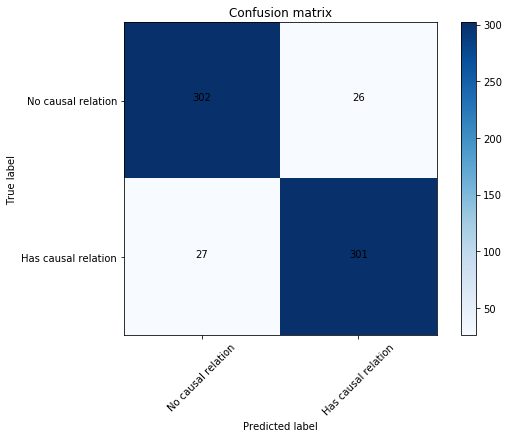

In [264]:
#kept the special token version
df_train_limited= df_train_balanced.sample(600)
test_pred,test_true,df_test = do_cls(df_train_limited,df_val_balanced,df_test_balanced,best_args)


======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Loading bert model.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training and evaluating the model.

======== Epoch 1 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.47
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.86
  Validation Loss: 0.33
  Validation took: 0:00:01

======== Epoch 2 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.20
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.89
  Validation Loss: 0.33
  Validation took: 0:00:01

======== Epoch 3 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.04
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.89
  Validation Loss: 0.49
  Validation took: 0:00:01

======== Epoch 4 / 6 ========
Training...
current lr is: 5e-05

  Average training loss: 0.01
  Training epcoh took: 0:00:04

Running Validation...
  Macro F1 score: 0.91
  Validation Loss: 0.45
  Validation took: 0:00:01

======== Epoch 5 / 6 ========
Training...
current lr is: 5e-05

  Avera

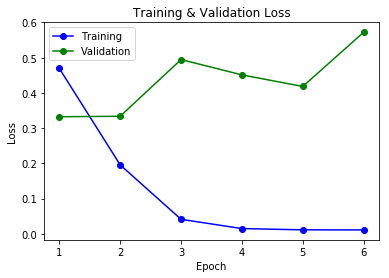

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'f1_train': 0.9966663332999967, 'f1_val': 0.8950130580773535, 'f1_test': 0.8524239811030707}

args: {'epochs': 6, 'batch_size': 20, 'max_length': 60, 'model_name': 'bert', 'lr': 5e-05, 'weight_decay': 0.05, 'freeze_layer_count': 0, 'scheduler_type': 'none', 'decayRate': 0.75}
classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.80      0.95      0.87       328
     class 1       0.93      0.76      0.84       328

    accuracy                           0.85       656
   macro avg       0.87      0.85      0.85       656
weighted avg       0.87      0.85      0.85       656

confusion matrix on test set is:



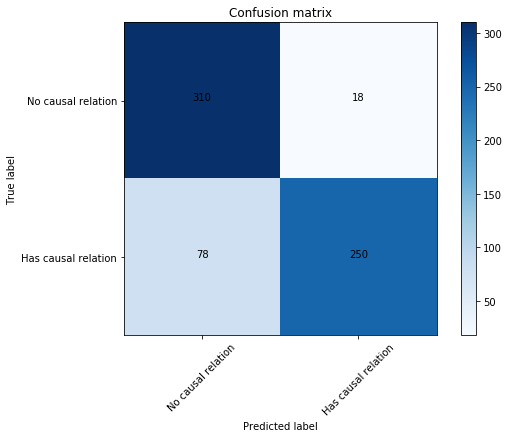

In [262]:
#removed the special token version
df_train_re_limited= df_train_re_balanced.sample(600)
test_pred,test_true,df_test = do_cls(df_train_re_limited,df_val_re_balanced,df_test_re_balanced,best_args)

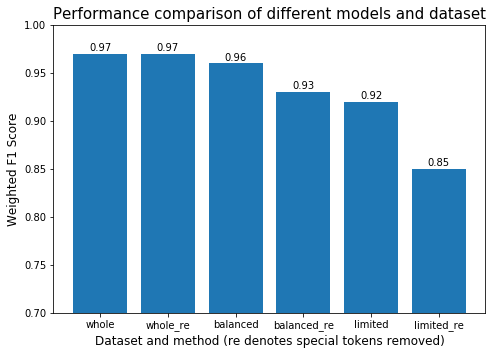

In [18]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

names = ['whole','whole_re','balanced','balanced_re','limited', 'limited_re']
scores = [0.97,0.97,0.96,0.93,0.92,0.85]
ax.bar(names, scores)
ax.set_ylabel('Weighted F1 Score', fontsize=12)
ax.set_xlabel('Dataset and method (re denotes special tokens removed)', fontsize=12)
ax.set_title('Performance comparison of different models and dataset', fontsize=15)
ax.set_ylim(0.7, 1)
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x() + p.get_width() / 2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 1),
                    textcoords="offset points", ha="center", va="bottom")
plt.show()

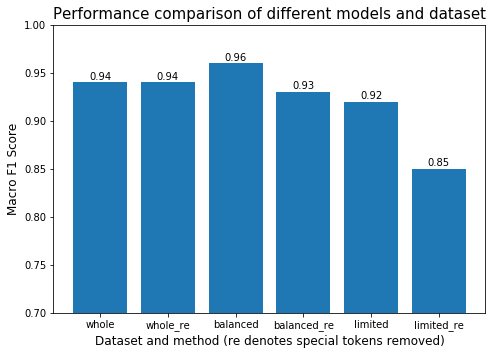

In [274]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

names = ['whole','whole_re','balanced','balanced_re','limited', 'limited_re']
scores = [0.94,0.94,0.96,0.93,0.92,0.85]
ax.bar(names, scores)
ax.set_ylabel('Macro F1 Score', fontsize=12)
ax.set_xlabel('Dataset and method (re denotes special tokens removed)', fontsize=12)
ax.set_title('Performance comparison of different models and dataset', fontsize=15)
ax.set_ylim(0.7, 1)
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x() + p.get_width() / 2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 1),
                    textcoords="offset points", ha="center", va="bottom")
plt.show()